In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Loading, cleaning and splitting data

In [14]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")
loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalLoanAmount = LoanAmount * Loan_Amount_Term) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus", "TotalLoanAmount", "TotalIncome")
loan_data

loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalLoanAmount,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,46080,6091
0,Graduate,Yes,3000,0,66,360,1,Y,23760,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,43200,4941
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,Graduate,No,2900,0,71,360,1,Y,25560,2900
3+,Graduate,No,4106,0,40,180,1,Y,7200,4106
0,Graduate,Yes,4583,0,133,360,0,N,47880,4583


## Data summary

In [22]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))
loan_train_summary

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3476.000,1599.439,105.3182,340.0000
Y,164,3643.268,1363.292,105.4451,338.7073


## Distributions of key predictors

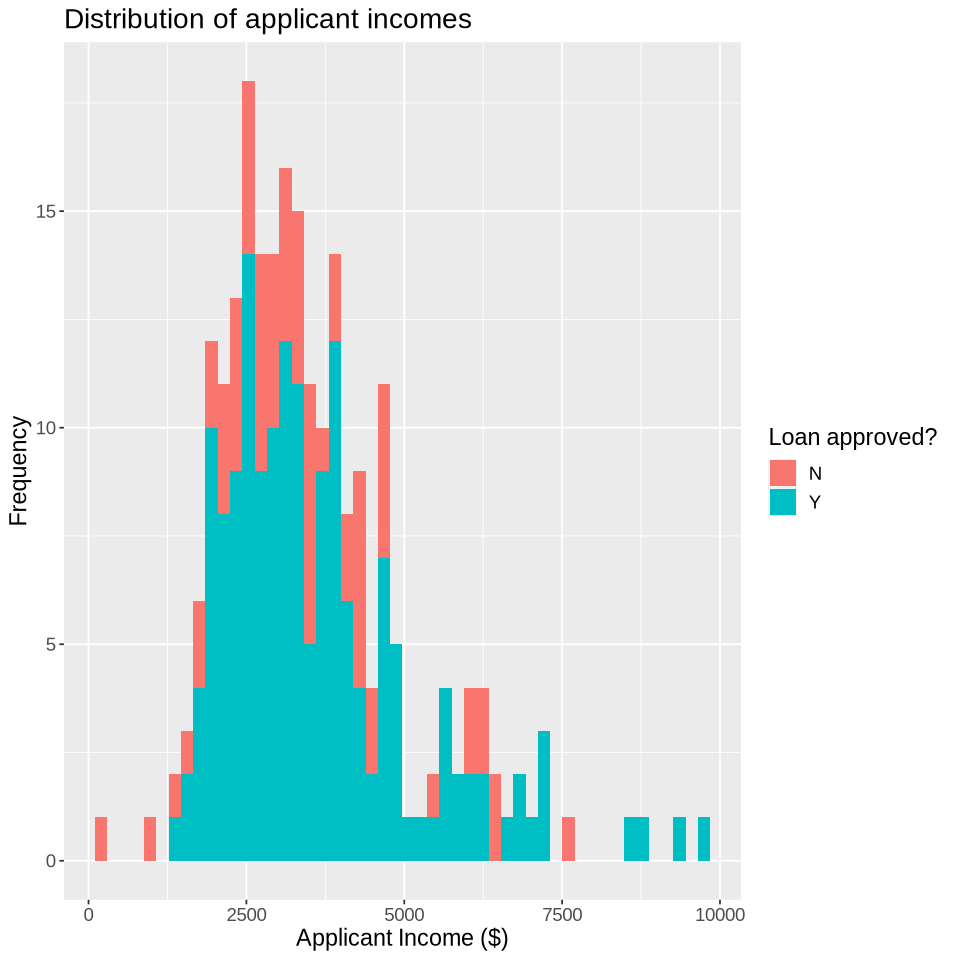

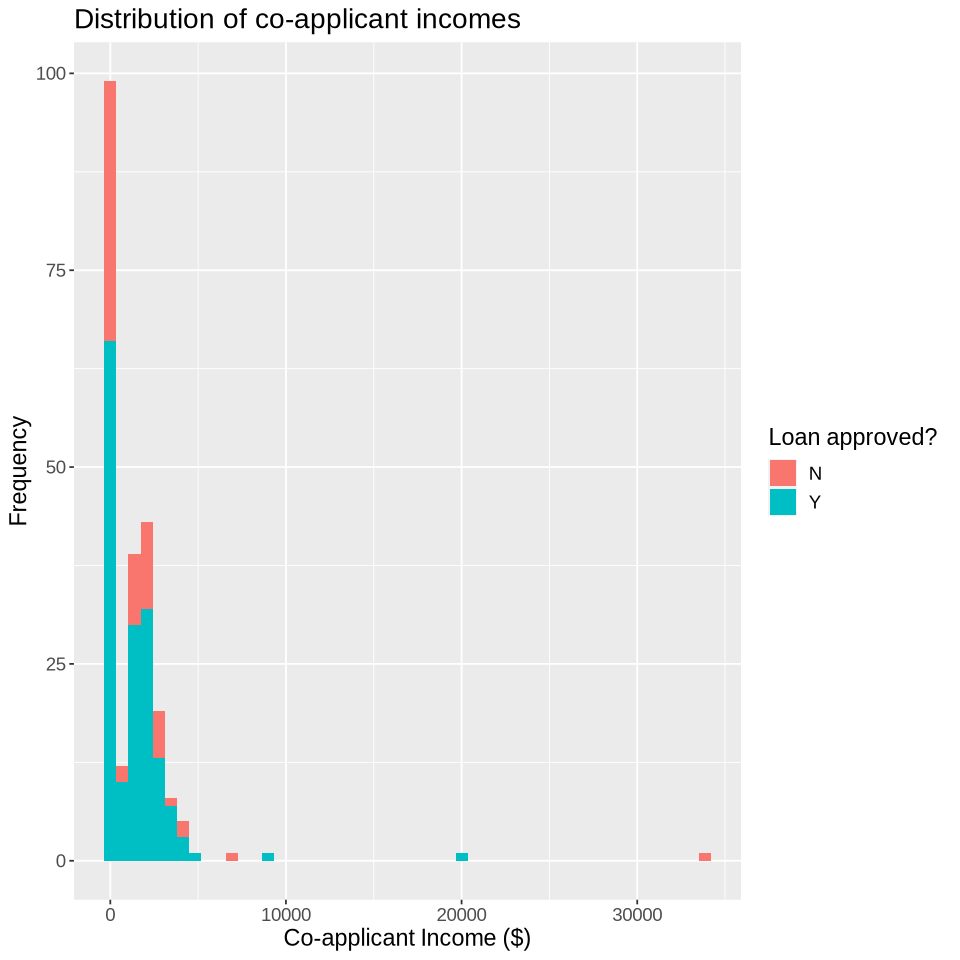

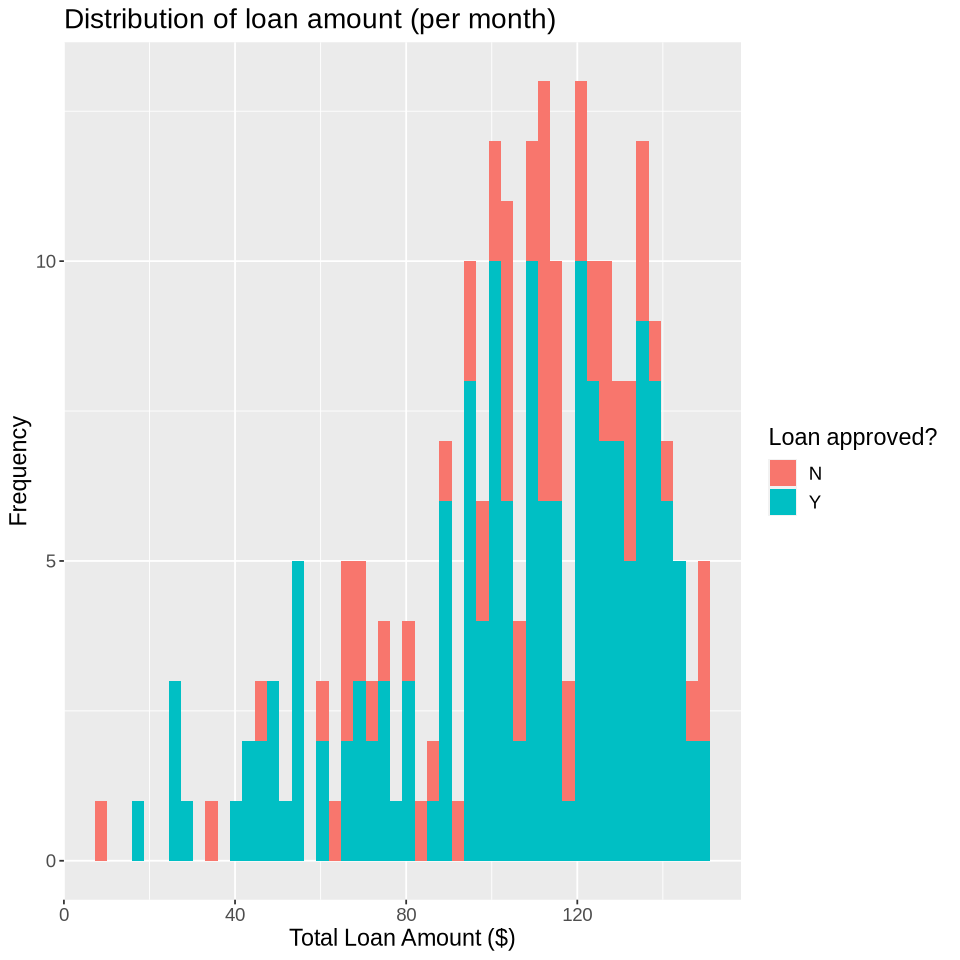

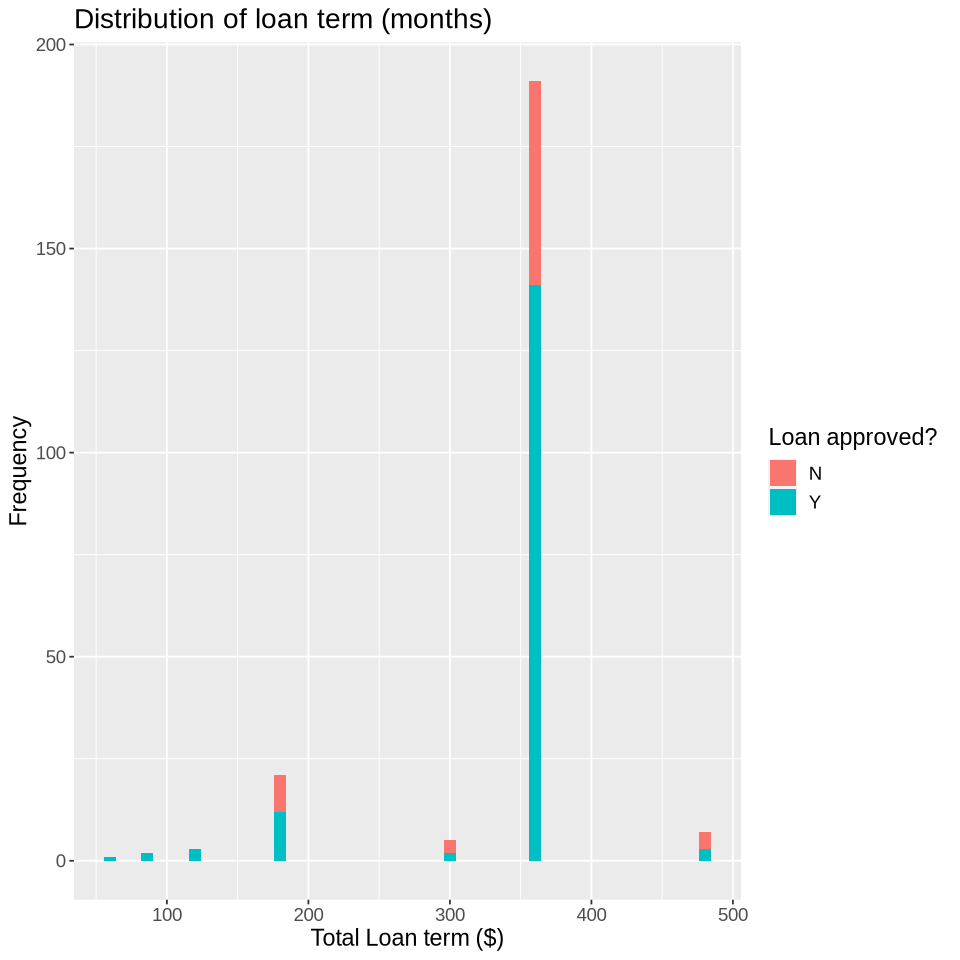

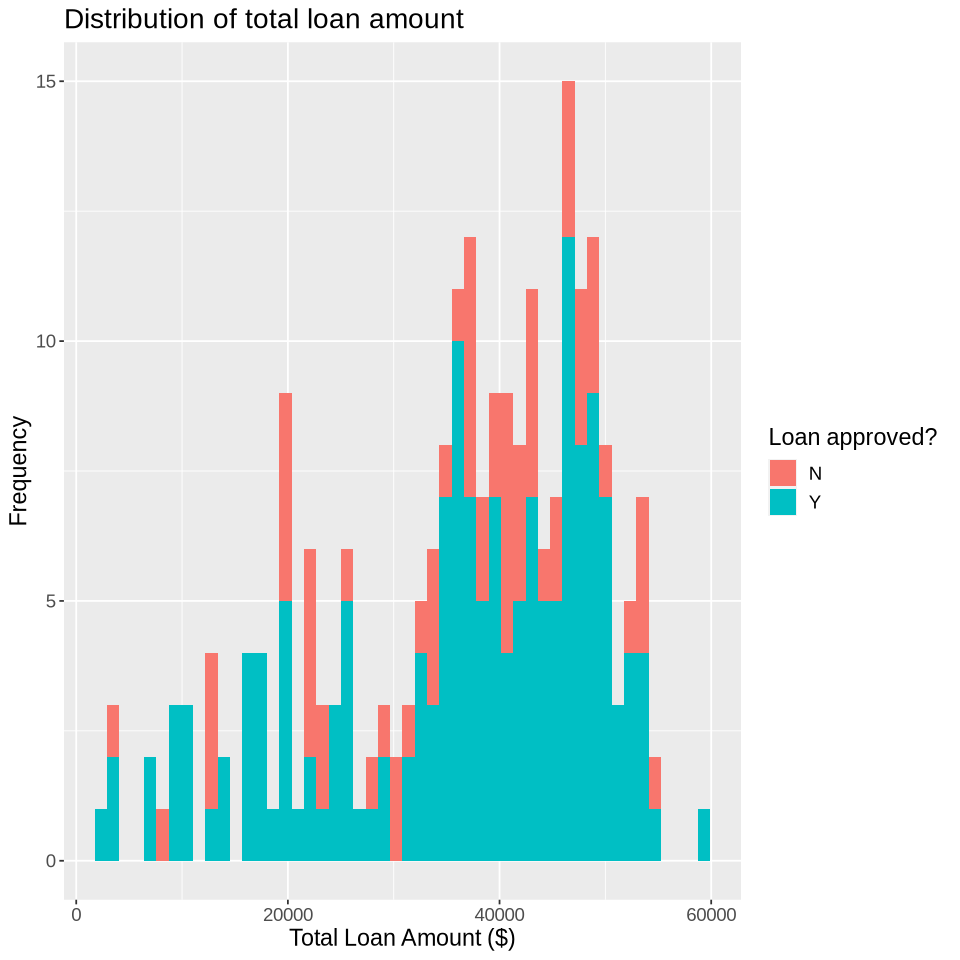

In [18]:
options(repr.plot.width=8, repr.plot.height=8)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
income_dist_plot

coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
coincome_dist_plot

loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_amount_plot

loan_term_plot <- loan_train |>
    ggplot(aes(x=LoanTerm, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_term_plot

loan_combined_plot <- loan_train |>
    ggplot(aes(x=TotalLoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of total loan amount", x = "Total Loan Amount ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_combined_plot

## Relationship between Income and Loan Amount

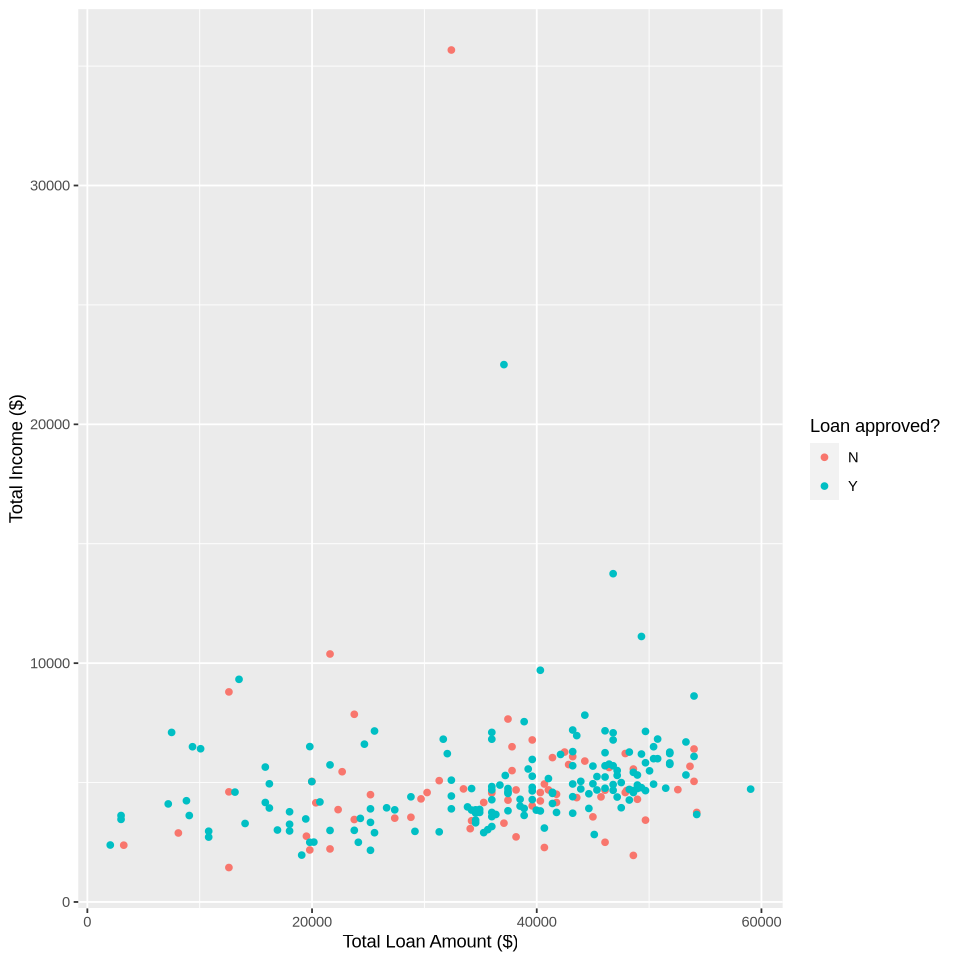

In [19]:
relationship_plot <- loan_train |>
    ggplot(aes(x=TotalLoanAmount, y=TotalIncome, color=LoanStatus)) +
    geom_point() + 
    labs(x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")
relationship_plot

## Methods

 We plan to use the following variables as predictors:
 - **ApplicantIncome**: Monthly income in dollars for main applicant
 - **CoapplicantIncome**: Monthly income in dollars for any coapplicants in main applicant's household
 - **LoanAmount**: Loan amount in thousands of dollars
 - **LoanTerm**: Loan term in months

In our preliminary data analysis, we made a data summary including the number of occurences for each class, and the mean values of the predictors we intend to use.

**(1)** There is almost twice as many positive LoanStatus class occurences as negative ones. This will lead to a class imbalance that affects the classifier performance. To solve this, we will need to either upsample the negative classes or downsample the positive classes.

**(2)** The predictors we intend to use has largely the same mean values for both the positive and negative classes. This could be due to large variance or outliers within the predictors affecting the mean.

We did visualisations involving the distributions of the predictors we intend to use. From the visualisations, we see that there are some class imbalances for outlier values, especially in applicant/coapplicant incomes and the loan term. This could lead to poor classification for new observations near the outlier values and may need to be removed.

We will also being doing visualisations involving scatter plots of the relationships between our predictors. This will allow us to determine if there is any clear grouping occuring. This will allow us to potentially determine which of our predictors are the most important in our classifier.